In [ ]:
import time
import numpy as np
import gymnasium as gym
from nlk1000_gym import NLK_Env
import matplotlib.pyplot as plt

# Register the environment
gym.register(
    id='NLK_Env-v0',
    entry_point='nlk1000_gym:NLK_Env'
)
env = gym.make('NLK_Env-v0')

import stable_baselines3
from stable_baselines3 import TD3
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [2]:
class NLK_Sampler:
    def __init__(self):
        self.lower = np.array([0.01242802014328473,-2.3510967845422677,
                                 135.64889234592374,-2621.6674111929387,8374.6738385004])
        self.upper = np.array([-0.026705410090359233,6.412451482988342,
                                 -549.8383734808201,20891.368558370945,-298723.030031348])
        self.diff = self.upper-self.lower
        self.transform = np.array([-3.2911361375977704,102.00328087158005,
                                   15593.102791660853,-518062.7698926044])
        self.poly = PolynomialFeatures(degree=4)
        self.poly_transform = PolynomialFeatures(degree=3)
    def sample(self):
        x = np.random.uniform(size=(1,1))
        x = x**1.8       #verstehe nicht ganz warum
        x = x*(22.85e-3-15e-3)+15e-3

        x_poly = self.poly_transform.fit_transform(x)
        x = x_poly@self.transform
        x = x*(22.85e-3-15e-3)+15e-3
        #x = self.poly_transform.fit_transform(x.reshape((1,1)))@self.transform
        x = np.array([[x[0]]])
        
        #x = np.random.uniform(low=15e-3, high=22.85e-3,size=(1,1))
        height = np.random.uniform()
        x_poly = self.poly.fit_transform(x)   #to x^0,x^1,...,x^4
        y = x_poly@self.lower + height*x_poly@self.diff
        return x[0,0],y[0]
    
nlk_sampler = NLK_Sampler()

In [4]:
from pathlib import Path
from thor_scsi.factory import accelerator_from_config
from thor_scsi.pyflame import Config
import thor_scsi.lib as tslib

import numpy as np
import matplotlib.pyplot as plt

import gtpsa
import os
import time
import copy
import copy
import random


from multiprocessing import Process, Queue, Array
from queue import Empty

from scipy.stats import truncnorm, norm



prefix = Path(os.environ["HOME"])
prefix = Path("/home/al3xber")
t_dir =  prefix / "Desktop" / "Workspace"
t_file = t_dir / "BII_NLKmode_3d_start.lat"   #file is provieded

x_, px_ = 0, 1
y_, py_ = 2, 3

emittance_start = 70e-9
nv = 6
mo = 1
default_desc = gtpsa.desc(nv, mo)


def create_nlk_interpolation(nlk_name):
    def compute_mirror_position_plate(ref_pos, mirror_pos, *, y_plane=True):
        assert y_plane
        dy = ref_pos.imag - mirror_pos.imag
        return ref_pos - 2 * dy * 1j

    # fmt: off
    ref_pos1 =  8e-3 +  7e-3j
    ref_pos2 = 17e-3 + 15e-3j
    # fmt: on
    t_current = -7e2

    # fmt: off
    t_current *= 1 - 1 * 0.14 / 2
    ref_pos1  *= 1 - 0.14
    ref_pos2  *= 1 - 0.14

    plate_position1 = 5e-3j
    mirror_pos1 = compute_mirror_position_plate(ref_pos1, plate_position1)

    inner = tslib.aircoil_filament(ref_pos1.real, ref_pos1.imag,  t_current)
    outer = tslib.aircoil_filament(ref_pos2.real, ref_pos2.imag, -t_current)
    mirror = tslib.aircoil_filament(mirror_pos1.real, mirror_pos1.imag, -t_current * 0.14)
    nlkf_intp = tslib.NonLinearKickerInterpolation([inner, outer, mirror])

    c = Config()
    c.setAny("L", 0e0)
    c.setAny("name", nlk_name)
    c.setAny("N", 1)
    nlk = tslib.FieldKick(c)
    nlk.set_field_interpolator(nlkf_intp)
    return nlk, nlkf_intp


def create_state_space_vector(*, mu_x=0e0, mu_px=0e0, mu_y=0e0, mu_py=0e0, desc=default_desc):
    #ps = gtpsa.ss_vect_double(desc, mo, nv)
    ps = gtpsa.ss_vect_double(0.0)
    #ps.set_identity()
    ps.set_zero()
    ps.x+=mu_x
    ps.px+=mu_px
    ps.y+=mu_y
    ps.py+=mu_py
    ps.copy()
    return ps


acc = accelerator_from_config(t_file)
calc_config = tslib.ConfigType()

#Description of NLK
nlkfk = acc.find("KDNL1KR", 0)
print(nlkfk)
nlk_name = nlkfk.name
_, nlkf_intp = create_nlk_interpolation(nlk_name)

nlkfk.set_field_interpolator(nlkf_intp)

<thor_scsi::core::CellVoid const* @ 0x558a77b37460>(cell 201: NonLinearKicker(KDNL1KR) aperture=None observer=None)


In [5]:
from particle_propagation import Particle_Propagator,calulate_sigma_px,emmitance_propagation,single_particle

Propagator=Particle_Propagator()

In [6]:
def encoder(points, x_normalization, px_normalization, normalized = True):
    #assert points are normalized!
    if not normalized:
        points[0,:]*=x_normalization
        points[1,:]*=px_normalization
        
    if (points.shape)[1] == 0:
        #check if points are contained
        return np.float32(np.zeros((2,))), np.uint8(np.zeros((1,51,51)))
    
    means = points.mean(axis = 1, dtype=np.float32)
    assert means.shape == (2,)
    
    range_xpx = np.array([0.006*x_normalization,0.0005*px_normalization])
    H,_,_ = np.histogram2d(points[0,:],points[1,:], bins=51, range = np.vstack([means-range_xpx,means+range_xpx]).T)
    
    
    if np.sum(H)!= 0:
        H = ((H/np.sum(H))*255).astype(np.uint8).T
    
    return means, H[None]   #[None] for (1,51,51) shape


In [7]:
def model_on_thscsi_on_point(x,px,model):
    #we check in this function the performance of the model for the input means: x,px
    
    sigma_x = 0.00112
    sigma_px = 6.29e-05
    
    x_normalization = 100
    px_normalization = 1000
    
    #less points, because of high time consumption
    x_points  = norm.rvs(loc = x, scale = sigma_x, size = 100) #generate random x points
    px_points = norm.rvs(loc = px, scale = sigma_px, size = 100)  #generate px points 

    points = np.vstack([x_points,px_points]) 

    points = points[:, points[0,:] > 0.015]   # remove points that are inside of septum


    NLK_activated = False
    runde = np.float32(np.array([0.0]))

    when_NLK_activated = 0

    while (not NLK_activated) and (points.shape[1] != 0):
        means, image = encoder(np.copy(points), x_normalization, px_normalization, normalized = False)

        obs = {"round": runde,
                "x,px mean": means,
                "image": image}

        action, _states = model.predict(obs)   #check what the model predicts


        if (abs(action[0])<=0.16):
            ##if no NLK is activated, add round to count when it is activated
            nlkf_intp.set_scale(0.0)
            when_NLK_activated += 1    
        else:
            #if kicker is acticated apply strength
            NLK_strength = np.sign(action[0])*(action[0]**4)
            nlkf_intp.set_scale(NLK_strength) 
            NLK_activated = True


        for j in range(points.shape[1]):
            ps = create_state_space_vector(mu_x=points[0,j],mu_px=points[1,j])

            result = acc.propagate(calc_config, ps)

            points[0,j] = ps.x
            points[1,j] = ps.px


        points = points[:, points[0,:] < 0.015]   # remove points that collided into septum

        runde += np.float32(1/100)


    if points.shape[1] == 0:

        return 0, when_NLK_activated
    
    result, _,_,_ = Propagator.run_1000(points[0,:],points[1,:],when_activate_NLK=10000,
                                        kicker_strength=1.0,noise_x=0.0, noise_px=0.0, 
                                        noise_NLK=0.0,noise_first_round=0.0)

    #print("SUM OF RESULT:", np.sum(result))
    return np.sum(result)*10, when_NLK_activated #*10, because less points are used

    


In [8]:
def model_on_thscsi(model):
    #check how a model performs on the drift kick simulation
    x_list = np.linspace(15e-3,22.85e-3,90)
    px_list = np.linspace(-0.0008,0.0012,45)
    
    Z = np.zeros((len(x_list),len(px_list)))
    Z_round = np.zeros((len(x_list),len(px_list)))

    poly = PolynomialFeatures(degree=4)
    nlk_sampler = NLK_Sampler()
        
    new_list = []
    counter = 0
    reward_sum = 0
    for i in tqdm.tqdm(range(len(x_list))):
        x_poly = poly.fit_transform(np.array([[x_list[i]]]))
        x_lower = x_poly@nlk_sampler.lower
        x_upper = x_poly@nlk_sampler.upper
        
        for j in range(len(px_list)):
            info = []
            if px_list[j]>x_lower and px_list[j]<x_upper:   #check if value is in injection area
                reward, round_kicked = model_on_thscsi_on_point(x_list[i],px_list[j],model)  #find performance on point
                
                reward_sum += reward
                
                #save information
                Z[i,j] = reward
                Z_round[i,j] = round_kicked
                
                counter+=1
            else:
                Z[i,j] = np.nan
                Z_round[i,j] = np.nan

    return reward_sum/counter, Z, Z_round

In [9]:
model = TD3.load("training_1000step_1000electron")   #load model

In [11]:
import time
a = time.time()
value, Z, Z_round = model_on_thscsi(model)
print(time.time()-a)
value

  0%|          | 0/90 [00:00<?, ?it/s]

Needed time: 24.611480712890625
Needed time: 24.84458017349243
Needed time: 24.71534490585327
Needed time: 24.753512859344482
Needed time: 24.981046199798584
Needed time: 26.70292353630066
Needed time: 24.746007204055786
Needed time: 26.84266948699951
Needed time: 24.743442058563232
Needed time: 24.69238042831421
Needed time: 24.75100588798523
Needed time: 4.497695446014404
Needed time: 26.77349829673767
Needed time: 24.903603315353394
Needed time: 26.85187077522278
Needed time: 26.793943405151367
Needed time: 24.719982862472534
Needed time: 24.729199647903442
Needed time: 26.704420804977417
Needed time: 26.737099409103394
Needed time: 26.73908257484436
Needed time: 26.796218156814575
Needed time: 26.718367338180542
Needed time: 26.75763177871704
Needed time: 4.489121675491333
Needed time: 26.660757780075073
Needed time: 26.75102686882019
Needed time: 26.778534412384033
Needed time: 26.717493772506714
Needed time: 26.686418771743774
Needed time: 4.4952497482299805
Needed time: 26.83442

  1%|          | 1/90 [16:33<24:33:32, 993.40s/it]

Needed time: 16.650425672531128
Needed time: 26.746660470962524
Needed time: 24.953437566757202
Needed time: 24.72818350791931
Needed time: 26.784393072128296
Needed time: 24.696937084197998
Needed time: 24.66932702064514
Needed time: 24.766675233840942
Needed time: 24.794971466064453
Needed time: 24.69404172897339
Needed time: 24.714377403259277
Needed time: 24.70256471633911
Needed time: 24.77920627593994
Needed time: 28.691206693649292
Needed time: 26.760112524032593
Needed time: 26.84505033493042
Needed time: 26.890802145004272
Needed time: 24.799811363220215
Needed time: 24.793243646621704
Needed time: 24.82023811340332
Needed time: 24.686441898345947
Needed time: 24.667619466781616
Needed time: 24.965485334396362
Needed time: 24.813859462738037
Needed time: 26.760053873062134
Needed time: 26.90097975730896
Needed time: 24.737825393676758
Needed time: 24.88401961326599
Needed time: 24.787196159362793
Needed time: 24.77022409439087
Needed time: 24.72734260559082
Needed time: 8.5067

  2%|▏         | 2/90 [33:21<24:29:55, 1002.23s/it]

Needed time: 12.623372316360474
Needed time: 24.732139587402344
Needed time: 24.72635507583618
Needed time: 24.70374321937561
Needed time: 24.733829259872437
Needed time: 24.680445909500122
Needed time: 24.709474563598633
Needed time: 24.835087060928345
Needed time: 24.7685387134552
Needed time: 24.854990005493164
Needed time: 22.685637712478638
Needed time: 22.8079354763031
Needed time: 24.798545122146606
Needed time: 24.874573945999146
Needed time: 24.915772914886475
Needed time: 24.737492084503174
Needed time: 24.73047423362732
Needed time: 25.02405881881714
Needed time: 24.70512342453003
Needed time: 24.801911115646362
Needed time: 24.811347484588623
Needed time: 24.8348491191864
Needed time: 24.745381116867065
Needed time: 24.75377106666565
Needed time: 24.618979692459106
Needed time: 6.509778022766113
Needed time: 26.75750422477722
Needed time: 24.76263737678528
Needed time: 28.875185251235962
Needed time: 28.88633108139038
Needed time: 30.800883054733276
Needed time: 4.522313117

  3%|▎         | 3/90 [49:52<24:05:37, 996.98s/it] 

Needed time: 16.645907402038574
Needed time: 24.659268856048584
Needed time: 24.74216651916504
Needed time: 24.734721183776855
Needed time: 26.801172018051147
Needed time: 24.819894790649414
Needed time: 26.72256851196289
Needed time: 24.81397032737732
Needed time: 24.790146112442017
Needed time: 24.7762234210968
Needed time: 24.70240807533264
Needed time: 22.810787439346313
Needed time: 8.707462072372437
Needed time: 26.83726739883423
Needed time: 26.754474878311157
Needed time: 26.873982667922974
Needed time: 26.897666215896606
Needed time: 24.872910499572754
Needed time: 26.73507070541382
Needed time: 26.763794422149658
Needed time: 26.803387880325317
Needed time: 26.896173238754272
Needed time: 24.921441078186035
Needed time: 26.93347978591919
Needed time: 24.884374380111694
Needed time: 4.469576358795166
Needed time: 26.746802806854248
Needed time: 26.94020700454712
Needed time: 26.794536352157593
Needed time: 24.78464102745056
Needed time: 24.74108362197876
Needed time: 4.5153625

  4%|▍         | 4/90 [1:06:21<23:44:27, 993.81s/it]

Needed time: 16.59371066093445
Needed time: 28.68019413948059
Needed time: 28.757728576660156
Needed time: 26.746191263198853
Needed time: 26.833007097244263
Needed time: 26.84316849708557
Needed time: 25.043071746826172
Needed time: 26.801454067230225
Needed time: 24.708293676376343
Needed time: 24.705716609954834
Needed time: 24.84853720664978
Needed time: 22.66852641105652
Needed time: 26.8081111907959
Needed time: 26.839590311050415
Needed time: 26.813461780548096
Needed time: 26.81106448173523
Needed time: 26.975204467773438
Needed time: 24.73220419883728
Needed time: 28.676586389541626
Needed time: 28.705852031707764
Needed time: 28.75811529159546
Needed time: 28.857901334762573
Needed time: 31.023313522338867
Needed time: 34.9767165184021
Needed time: 32.99598670005798
Needed time: 33.05299735069275
Needed time: 33.011449575424194
Needed time: 32.999765396118164
Needed time: 32.95751595497131
Needed time: 32.83001255989075
Needed time: 32.86173057556152
Needed time: 4.5584027767

  6%|▌         | 5/90 [1:26:16<25:10:34, 1066.28s/it]

Needed time: 20.861589908599854
Needed time: 35.12532877922058
Needed time: 34.94224786758423
Needed time: 32.96355438232422
Needed time: 34.97649049758911
Needed time: 33.03958249092102
Needed time: 35.05479621887207
Needed time: 30.98768138885498
Needed time: 31.003072500228882
Needed time: 32.956212520599365
Needed time: 26.853431940078735
Needed time: 34.95705056190491
Needed time: 35.032827377319336
Needed time: 35.0190486907959
Needed time: 34.90990877151489
Needed time: 34.947901248931885
Needed time: 35.06364154815674
Needed time: 35.02388787269592
Needed time: 35.129852533340454
Needed time: 33.001219749450684
Needed time: 35.129669189453125
Needed time: 33.13364267349243
Needed time: 35.05767345428467
Needed time: 34.98879885673523
Needed time: 4.690041542053223
Needed time: 35.080857276916504
Needed time: 35.20843958854675
Needed time: 35.22207736968994
Needed time: 35.11426520347595
Needed time: 33.11952328681946
Needed time: 35.037792921066284
Needed time: 34.8887395858764

  7%|▋         | 6/90 [1:48:27<26:58:51, 1156.32s/it]

Needed time: 22.880492210388184
Needed time: 35.03356051445007
Needed time: 33.175625801086426
Needed time: 35.05866885185242
Needed time: 35.275158405303955
Needed time: 35.228890895843506
Needed time: 35.0633487701416
Needed time: 35.12987399101257
Needed time: 30.845824003219604
Needed time: 27.062835216522217
Needed time: 26.83248019218445
Needed time: 35.185412883758545
Needed time: 33.13710069656372
Needed time: 35.16991901397705
Needed time: 35.05741357803345
Needed time: 35.102006673812866
Needed time: 32.98786902427673
Needed time: 33.091529846191406
Needed time: 35.060795545578
Needed time: 36.98808479309082
Needed time: 28.947272539138794
Needed time: 26.891931295394897
Needed time: 26.944881916046143
Needed time: 29.055052995681763
Needed time: 26.773036241531372
Needed time: 28.954705238342285
Needed time: 30.913419723510742
Needed time: 26.813787937164307
Needed time: 26.845593452453613
Needed time: 26.809812784194946
Needed time: 28.750540018081665
Needed time: 28.790378

  8%|▊         | 7/90 [2:08:42<27:06:17, 1175.63s/it]

Needed time: 18.69232726097107
Needed time: 26.805689811706543
Needed time: 28.80209994316101
Needed time: 26.71535301208496
Needed time: 26.878756523132324
Needed time: 26.80719518661499
Needed time: 26.740322828292847
Needed time: 26.83447551727295
Needed time: 28.740524291992188
Needed time: 24.808927536010742
Needed time: 24.673652172088623
Needed time: 26.732381105422974
Needed time: 26.8405544757843
Needed time: 26.708473443984985
Needed time: 27.042271375656128
Needed time: 26.701282024383545
Needed time: 26.75788688659668
Needed time: 24.835211277008057
Needed time: 24.781494855880737
Needed time: 26.887789964675903
Needed time: 26.787555694580078
Needed time: 24.829641819000244
Needed time: 29.044482707977295
Needed time: 26.819766998291016
Needed time: 26.755486726760864
Needed time: 26.933851957321167
Needed time: 26.77898931503296
Needed time: 26.829963207244873
Needed time: 26.864240884780884
Needed time: 24.761390447616577
Needed time: 4.462665319442749
Needed time: 26.67

  9%|▉         | 8/90 [2:25:54<25:44:18, 1129.98s/it]

Needed time: 18.641308784484863
Needed time: 26.692254066467285
Needed time: 26.80555534362793
Needed time: 26.817437648773193
Needed time: 28.798421621322632
Needed time: 26.96870231628418
Needed time: 26.730604648590088
Needed time: 26.803434371948242
Needed time: 26.823262691497803
Needed time: 24.704777717590332
Needed time: 22.695786237716675
Needed time: 26.863006591796875
Needed time: 26.91462516784668
Needed time: 26.80980634689331
Needed time: 26.76429557800293
Needed time: 26.827855587005615
Needed time: 26.693440198898315
Needed time: 24.86232876777649
Needed time: 26.673421144485474
Needed time: 26.803945541381836
Needed time: 24.779643774032593
Needed time: 24.86614465713501
Needed time: 24.940847158432007
Needed time: 26.861658573150635
Needed time: 24.882291555404663
Needed time: 26.771594285964966
Needed time: 24.689018726348877
Needed time: 24.78160810470581
Needed time: 24.675456285476685
Needed time: 24.82024359703064
Needed time: 4.46751856803894
Needed time: 24.753

 10%|█         | 9/90 [2:42:48<24:36:31, 1093.72s/it]

Needed time: 18.647279739379883
Needed time: 24.74496865272522
Needed time: 26.742736339569092
Needed time: 25.003015756607056
Needed time: 27.0134060382843
Needed time: 26.91042947769165
Needed time: 26.885812520980835
Needed time: 26.9137225151062
Needed time: 22.682397842407227
Needed time: 24.818687677383423
Needed time: 20.63586187362671
Needed time: 26.66676425933838
Needed time: 26.736167907714844
Needed time: 26.940441370010376
Needed time: 29.007768630981445
Needed time: 28.912279844284058
Needed time: 26.91211223602295
Needed time: 26.966450214385986
Needed time: 26.8885338306427
Needed time: 28.869157075881958
Needed time: 28.81539249420166
Needed time: 26.898977518081665
Needed time: 26.87042808532715
Needed time: 24.734749794006348
Needed time: 24.809073209762573
Needed time: 26.807760000228882
Needed time: 26.82815909385681
Needed time: 26.865622758865356
Needed time: 26.817127466201782
Needed time: 24.893381595611572
Needed time: 24.997793197631836
Needed time: 24.781779

 11%|█         | 10/90 [3:00:09<23:56:28, 1077.36s/it]

Needed time: 20.84700870513916
Needed time: 26.74998712539673
Needed time: 24.801201581954956
Needed time: 24.794208526611328
Needed time: 24.87813138961792
Needed time: 26.751726627349854
Needed time: 24.881914138793945
Needed time: 24.91270923614502
Needed time: 22.819562911987305
Needed time: 22.832677841186523
Needed time: 24.741291046142578
Needed time: 24.85234832763672
Needed time: 24.77853488922119
Needed time: 24.83039093017578
Needed time: 26.787386417388916
Needed time: 24.790959119796753
Needed time: 24.885079860687256
Needed time: 24.84222674369812
Needed time: 24.876158475875854
Needed time: 24.78725552558899
Needed time: 24.78328800201416
Needed time: 24.845895528793335
Needed time: 24.781298637390137
Needed time: 24.9410183429718
Needed time: 14.761092185974121
Needed time: 24.831578254699707
Needed time: 24.825220584869385
Needed time: 24.73245406150818
Needed time: 24.759754180908203
Needed time: 24.669534921646118
Needed time: 24.843688249588013
Needed time: 24.83606

 12%|█▏        | 11/90 [3:16:33<23:00:39, 1048.60s/it]

Needed time: 14.680908441543579
Needed time: 24.79534649848938
Needed time: 26.79663848876953
Needed time: 26.936492204666138
Needed time: 26.77359366416931
Needed time: 26.879738092422485
Needed time: 24.718001127243042
Needed time: 24.895983457565308
Needed time: 20.68607211112976
Needed time: 18.765612602233887
Needed time: 26.99484872817993
Needed time: 25.01587724685669
Needed time: 26.856228590011597
Needed time: 26.823017358779907
Needed time: 31.39420437812805
Needed time: 31.114110469818115
Needed time: 28.95124316215515
Needed time: 30.9325168132782
Needed time: 26.94010901451111
Needed time: 28.94227647781372
Needed time: 26.818601369857788
Needed time: 25.08128571510315
Needed time: 26.79077386856079
Needed time: 24.89875864982605
Needed time: 24.813866138458252
Needed time: 26.903769969940186
Needed time: 28.870550870895386
Needed time: 26.83442211151123
Needed time: 26.799060106277466
Needed time: 24.79396629333496
Needed time: 24.867408990859985
Needed time: 24.748032331

 13%|█▎        | 12/90 [3:33:44<22:36:30, 1043.47s/it]

Needed time: 18.713557720184326
Needed time: 26.716648817062378
Needed time: 28.86539387702942
Needed time: 32.86859488487244
Needed time: 26.986702919006348
Needed time: 31.0562961101532
Needed time: 33.09807109832764
Needed time: 30.994909524917603
Needed time: 26.931058406829834
Needed time: 26.973265886306763
Needed time: 32.917202949523926
Needed time: 28.80096960067749
Needed time: 33.00689435005188
Needed time: 33.179060220718384
Needed time: 35.246272563934326
Needed time: 33.026466846466064
Needed time: 30.8221595287323
Needed time: 26.966891050338745
Needed time: 28.803386926651
Needed time: 30.876871347427368
Needed time: 28.83231782913208
Needed time: 31.087364196777344
Needed time: 30.752569675445557
Needed time: 30.811044692993164
Needed time: 30.80528998374939
Needed time: 28.79641318321228
Needed time: 26.817232608795166
Needed time: 26.84568214416504
Needed time: 26.78740429878235
Needed time: 24.86457133293152
Needed time: 24.773391246795654
Needed time: 24.8080661296

 14%|█▍        | 13/90 [3:52:25<22:49:03, 1066.80s/it]

Needed time: 18.70816993713379
Needed time: 24.712843894958496
Needed time: 24.885819673538208
Needed time: 24.789763689041138
Needed time: 24.732614994049072
Needed time: 24.824547052383423
Needed time: 24.860607862472534
Needed time: 22.946218252182007
Needed time: 20.82730722427368
Needed time: 16.69150710105896
Needed time: 24.89146137237549
Needed time: 24.768558025360107
Needed time: 24.77673840522766
Needed time: 24.85681438446045
Needed time: 24.81358766555786
Needed time: 26.819271326065063
Needed time: 24.808146476745605
Needed time: 24.72539758682251
Needed time: 26.88166308403015
Needed time: 24.81742024421692
Needed time: 26.811882972717285
Needed time: 24.883030891418457
Needed time: 24.839009046554565
Needed time: 24.711106300354004
Needed time: 24.795413494110107
Needed time: 24.808347940444946
Needed time: 24.853065967559814
Needed time: 26.690065145492554
Needed time: 24.71040439605713
Needed time: 24.98507809638977
Needed time: 4.459593057632446
Needed time: 24.77184

 16%|█▌        | 14/90 [4:08:32<21:53:09, 1036.71s/it]

Needed time: 24.910025119781494
Needed time: 26.843186616897583
Needed time: 24.929691314697266
Needed time: 26.828871250152588
Needed time: 24.891967058181763
Needed time: 24.885735750198364
Needed time: 22.719693422317505
Needed time: 24.711656093597412
Needed time: 20.730342864990234
Needed time: 18.808085918426514
Needed time: 24.787325620651245
Needed time: 24.884469747543335
Needed time: 26.75068497657776
Needed time: 26.763472318649292
Needed time: 26.76108479499817
Needed time: 26.95259189605713
Needed time: 26.674572467803955
Needed time: 26.837618350982666
Needed time: 26.992506742477417
Needed time: 26.860122203826904
Needed time: 24.92352294921875
Needed time: 26.951277017593384
Needed time: 28.852490425109863
Needed time: 28.965981483459473
Needed time: 28.943459510803223
Needed time: 26.95873522758484
Needed time: 27.007720947265625
Needed time: 26.878273487091064
Needed time: 26.892924547195435
Needed time: 26.90542984008789
Needed time: 28.974318027496338
Needed time: 2

 17%|█▋        | 15/90 [4:25:31<21:29:22, 1031.51s/it]

Needed time: 18.598763704299927
Needed time: 26.813318967819214
Needed time: 26.807646989822388
Needed time: 26.706700086593628
Needed time: 28.930717945098877
Needed time: 22.8234121799469
Needed time: 24.730578660964966
Needed time: 22.821696281433105
Needed time: 20.65948724746704
Needed time: 26.847943544387817
Needed time: 26.701468229293823
Needed time: 27.0114848613739
Needed time: 26.85476040840149
Needed time: 26.977659225463867
Needed time: 28.941083908081055
Needed time: 26.84912419319153
Needed time: 26.83294129371643
Needed time: 26.97202968597412
Needed time: 28.772019624710083
Needed time: 26.668755769729614
Needed time: 26.963205337524414
Needed time: 26.836760759353638
Needed time: 4.492948055267334
Needed time: 24.9212007522583
Needed time: 26.871970653533936
Needed time: 26.9091055393219
Needed time: 26.91643476486206
Needed time: 27.029303789138794
Needed time: 26.833855628967285
Needed time: 26.857667684555054
Needed time: 26.77063775062561
Needed time: 26.86142611

 18%|█▊        | 16/90 [4:42:01<20:56:29, 1018.77s/it]

Needed time: 22.75978946685791
Needed time: 26.83882164955139
Needed time: 26.890053033828735
Needed time: 26.675315380096436
Needed time: 24.87931728363037
Needed time: 26.82430386543274
Needed time: 22.788018703460693
Needed time: 20.78583312034607
Needed time: 20.83215570449829
Needed time: 27.00606894493103
Needed time: 26.93512988090515
Needed time: 26.894840955734253
Needed time: 25.001432180404663
Needed time: 26.90684986114502
Needed time: 26.8647780418396
Needed time: 26.892107486724854
Needed time: 26.765548944473267
Needed time: 29.09963870048523
Needed time: 28.789796829223633
Needed time: 31.362619400024414
Needed time: 26.98342728614807
Needed time: 26.983986139297485
Needed time: 4.471127033233643
Needed time: 29.103816509246826
Needed time: 28.868943691253662
Needed time: 29.017487049102783
Needed time: 26.988137245178223
Needed time: 26.787261962890625
Needed time: 28.952508211135864
Needed time: 26.704176425933838
Needed time: 26.860628843307495
Needed time: 26.916849

 19%|█▉        | 17/90 [4:58:36<20:30:52, 1011.68s/it]

Needed time: 18.877243757247925
Needed time: 26.772927284240723
Needed time: 26.95314121246338
Needed time: 26.905802965164185
Needed time: 24.78729748725891
Needed time: 24.741041660308838
Needed time: 24.791353464126587
Needed time: 18.77958917617798
Needed time: 20.75853991508484
Needed time: 26.85070824623108
Needed time: 26.801203727722168
Needed time: 28.918935537338257
Needed time: 26.768706798553467
Needed time: 28.825788736343384
Needed time: 26.820390224456787
Needed time: 26.80412745475769
Needed time: 28.930284023284912
Needed time: 26.829681396484375
Needed time: 26.881865978240967
Needed time: 26.96119475364685
Needed time: 26.92252516746521
Needed time: 26.877979516983032
Needed time: 26.945713996887207
Needed time: 27.01106572151184
Needed time: 27.007529258728027
Needed time: 24.93095588684082
Needed time: 26.91152811050415
Needed time: 26.97794771194458
Needed time: 26.752007722854614
Needed time: 4.478183031082153
Needed time: 26.692114114761353
Needed time: 26.90037

 20%|██        | 18/90 [5:15:00<20:04:01, 1003.35s/it]

Needed time: 20.842395067214966
Needed time: 28.860593557357788
Needed time: 28.921780109405518
Needed time: 26.897393226623535
Needed time: 26.850356340408325
Needed time: 22.84425401687622
Needed time: 20.75031042098999
Needed time: 18.709128618240356
Needed time: 16.73721480369568
Needed time: 24.873370885849
Needed time: 24.968444347381592
Needed time: 24.865827322006226
Needed time: 26.941385746002197
Needed time: 26.719097137451172
Needed time: 24.90014123916626
Needed time: 24.821579456329346
Needed time: 26.78394341468811
Needed time: 26.914946794509888
Needed time: 26.832051992416382
Needed time: 26.72111201286316
Needed time: 26.79305148124695
Needed time: 24.676953077316284
Needed time: 4.472733497619629
Needed time: 24.777751922607422
Needed time: 26.884358882904053
Needed time: 26.73162317276001
Needed time: 24.850308656692505
Needed time: 24.853495597839355
Needed time: 24.87265634536743
Needed time: 26.855390548706055
Needed time: 24.85868811607361
Needed time: 24.831707

 21%|██        | 19/90 [5:30:28<19:20:24, 980.63s/it] 

Needed time: 24.811368465423584
Needed time: 24.907179594039917
Needed time: 24.87563419342041
Needed time: 24.783504486083984
Needed time: 22.787977695465088
Needed time: 20.783702611923218
Needed time: 18.665092945098877
Needed time: 18.68586039543152
Needed time: 26.773837089538574
Needed time: 24.869803190231323
Needed time: 24.84420919418335
Needed time: 27.00981092453003
Needed time: 24.943169593811035
Needed time: 26.842870712280273
Needed time: 26.86710810661316
Needed time: 26.881138801574707
Needed time: 26.769920349121094
Needed time: 24.974952220916748
Needed time: 26.809382438659668
Needed time: 26.88060212135315
Needed time: 24.89480233192444
Needed time: 26.851329565048218
Needed time: 26.79005455970764
Needed time: 24.87198495864868
Needed time: 26.762786149978638
Needed time: 24.93258023262024
Needed time: 26.706782579421997
Needed time: 24.774708032608032
Needed time: 12.623844623565674
Needed time: 25.06111717224121
Needed time: 26.934394598007202
Needed time: 24.944

 22%|██▏       | 20/90 [5:45:33<18:37:41, 958.03s/it]

Needed time: 24.878784656524658
Needed time: 24.73436713218689
Needed time: 24.83153247833252
Needed time: 24.793219804763794
Needed time: 20.76305055618286
Needed time: 20.780515670776367
Needed time: 16.72447657585144
Needed time: 18.748114109039307
Needed time: 24.8025324344635
Needed time: 26.7313871383667
Needed time: 26.70381784439087
Needed time: 26.9898841381073
Needed time: 25.002155303955078
Needed time: 26.73291540145874
Needed time: 26.725472927093506
Needed time: 27.13797163963318
Needed time: 24.776821851730347
Needed time: 26.855161428451538
Needed time: 27.00727677345276
Needed time: 24.97046208381653
Needed time: 24.834956407546997
Needed time: 26.971510887145996
Needed time: 26.951195240020752
Needed time: 26.825982809066772
Needed time: 24.858155250549316
Needed time: 27.04519534111023
Needed time: 26.880674839019775
Needed time: 26.905583381652832
Needed time: 4.482388257980347
Needed time: 24.87202548980713
Needed time: 26.957924842834473
Needed time: 26.7395493984

 23%|██▎       | 21/90 [6:00:34<18:02:05, 940.95s/it]

Needed time: 26.787206411361694
Needed time: 24.80950117111206
Needed time: 24.83259105682373
Needed time: 22.832565546035767
Needed time: 24.919870138168335
Needed time: 20.706330060958862
Needed time: 18.729605197906494
Needed time: 18.8075430393219
Needed time: 24.766127824783325
Needed time: 24.99083924293518
Needed time: 26.893266916275024
Needed time: 26.82639217376709
Needed time: 26.846139907836914
Needed time: 24.85338807106018
Needed time: 26.968947649002075
Needed time: 24.9091899394989
Needed time: 26.878509998321533
Needed time: 26.832350492477417
Needed time: 24.971254587173462
Needed time: 24.884317874908447
Needed time: 26.841070413589478
Needed time: 26.68265438079834
Needed time: 26.772878646850586
Needed time: 24.95014524459839
Needed time: 26.9454243183136
Needed time: 24.87173318862915
Needed time: 26.741729021072388
Needed time: 26.835870027542114
Needed time: 26.92576503753662
Needed time: 24.899672746658325
Needed time: 26.87651228904724
Needed time: 24.95666027

 24%|██▍       | 22/90 [6:15:54<17:39:14, 934.63s/it]

Needed time: 24.804948568344116
Needed time: 24.932010889053345
Needed time: 26.898964643478394
Needed time: 22.942697763442993
Needed time: 22.901078701019287
Needed time: 20.823628664016724
Needed time: 18.611298322677612
Needed time: 14.680891275405884
Needed time: 24.848050832748413
Needed time: 24.911110639572144
Needed time: 26.85448384284973
Needed time: 26.80089259147644
Needed time: 26.89691710472107
Needed time: 26.69302535057068
Needed time: 24.87458038330078
Needed time: 26.836233139038086
Needed time: 26.962371587753296
Needed time: 26.742695569992065
Needed time: 26.809473514556885
Needed time: 24.915801525115967
Needed time: 24.954679489135742
Needed time: 4.4766786098480225
Needed time: 26.809335470199585
Needed time: 24.89372754096985
Needed time: 26.908349990844727
Needed time: 24.858364820480347
Needed time: 26.87423825263977
Needed time: 26.70831799507141
Needed time: 4.463125705718994
Needed time: 26.837192058563232
Needed time: 24.932613372802734
Needed time: 26.9

 26%|██▌       | 23/90 [6:30:29<17:03:37, 916.67s/it]

Needed time: 24.85247564315796
Needed time: 24.859214305877686
Needed time: 24.939868927001953
Needed time: 20.81375813484192
Needed time: 18.688292264938354
Needed time: 16.78577494621277
Needed time: 12.636942148208618
Needed time: 26.757792949676514
Needed time: 24.810169458389282
Needed time: 26.813497066497803
Needed time: 26.914191484451294
Needed time: 26.915460109710693
Needed time: 26.776463747024536
Needed time: 24.910311937332153
Needed time: 26.990278244018555
Needed time: 26.903767585754395
Needed time: 26.678115606307983
Needed time: 26.924343824386597
Needed time: 26.84392476081848
Needed time: 24.827666997909546
Needed time: 26.940826416015625
Needed time: 24.841950178146362
Needed time: 26.894790649414062
Needed time: 27.02450180053711
Needed time: 26.90555763244629
Needed time: 26.808083295822144
Needed time: 26.818511247634888
Needed time: 4.4581663608551025
Needed time: 24.888622522354126
Needed time: 26.8749737739563
Needed time: 26.812909364700317
Needed time: 26.

 27%|██▋       | 24/90 [6:45:00<16:33:31, 903.20s/it]

Needed time: 26.762827157974243
Needed time: 24.804794311523438
Needed time: 22.902371406555176
Needed time: 20.724185466766357
Needed time: 20.674864530563354
Needed time: 20.769395351409912
Needed time: 14.7012779712677
Needed time: 24.904778242111206
Needed time: 24.90778088569641
Needed time: 26.768728017807007
Needed time: 26.890629053115845
Needed time: 26.850714445114136
Needed time: 26.792291402816772
Needed time: 26.952641487121582
Needed time: 24.915133476257324
Needed time: 26.80816650390625
Needed time: 26.73847508430481
Needed time: 24.904219150543213
Needed time: 26.703222513198853
Needed time: 24.94709610939026
Needed time: 26.872373819351196
Needed time: 26.88188076019287
Needed time: 26.83923625946045
Needed time: 24.91297149658203
Needed time: 26.7754864692688
Needed time: 26.818088054656982
Needed time: 24.93613052368164
Needed time: 26.78143048286438
Needed time: 26.837573528289795
Needed time: 26.743438005447388
Needed time: 26.731691598892212
Needed time: 26.83820

 28%|██▊       | 25/90 [6:59:56<16:16:06, 901.03s/it]

Needed time: 26.88686490058899
Needed time: 24.89844822883606
Needed time: 24.891781091690063
Needed time: 22.924009084701538
Needed time: 18.617391109466553
Needed time: 16.71960210800171
Needed time: 14.611958503723145
Needed time: 24.83569836616516
Needed time: 26.952568292617798
Needed time: 26.817750453948975
Needed time: 26.910895586013794
Needed time: 26.84850573539734
Needed time: 26.760085582733154
Needed time: 26.845381259918213
Needed time: 24.89075016975403
Needed time: 26.81861400604248
Needed time: 26.879791259765625
Needed time: 27.01429796218872
Needed time: 24.799723386764526
Needed time: 24.806068181991577
Needed time: 4.4764604568481445
Needed time: 24.88940715789795
Needed time: 26.87782645225525
Needed time: 27.000527143478394
Needed time: 24.954927444458008
Needed time: 26.821661472320557
Needed time: 24.873754262924194
Needed time: 26.87876868247986
Needed time: 26.90383005142212
Needed time: 26.77172327041626
Needed time: 26.718964338302612
Needed time: 26.67215

 29%|██▉       | 26/90 [7:14:28<15:51:42, 892.23s/it]

Needed time: 24.98433566093445
Needed time: 22.834577560424805
Needed time: 18.65796947479248
Needed time: 20.70871615409851
Needed time: 14.680766105651855
Needed time: 12.653911828994751
Needed time: 24.734530925750732
Needed time: 26.672156810760498
Needed time: 26.8784601688385
Needed time: 26.826882362365723
Needed time: 24.92550539970398
Needed time: 26.79121971130371
Needed time: 26.90778684616089
Needed time: 26.914662837982178
Needed time: 26.83634114265442
Needed time: 26.823856592178345
Needed time: 26.70500659942627
Needed time: 24.83018207550049
Needed time: 26.899476051330566
Needed time: 26.76949405670166
Needed time: 26.914272785186768
Needed time: 26.82811188697815
Needed time: 24.981712818145752
Needed time: 26.781708478927612
Needed time: 26.697641611099243
Needed time: 26.87925696372986
Needed time: 24.931781768798828
Needed time: 26.828215837478638
Needed time: 26.865089654922485
Needed time: 26.77412462234497
Needed time: 26.874836683273315
Needed time: 26.7363638

 30%|███       | 27/90 [7:28:52<15:27:57, 883.78s/it]

Needed time: 24.8505220413208
Needed time: 22.737496376037598
Needed time: 20.70935821533203
Needed time: 18.715996980667114
Needed time: 12.627483129501343
Needed time: 16.860249280929565
Needed time: 24.868186473846436
Needed time: 24.94660520553589
Needed time: 27.025634765625
Needed time: 26.824208736419678
Needed time: 26.842098474502563
Needed time: 26.918102502822876
Needed time: 26.86246681213379
Needed time: 26.826668739318848
Needed time: 26.892475128173828
Needed time: 26.911114931106567
Needed time: 26.813753128051758
Needed time: 26.892204761505127
Needed time: 20.781837701797485
Needed time: 24.938499927520752
Needed time: 26.85772728919983
Needed time: 26.773435354232788
Needed time: 26.92464566230774
Needed time: 24.897041082382202
Needed time: 26.88551664352417
Needed time: 26.87225580215454
Needed time: 26.824644327163696
Needed time: 26.814669370651245
Needed time: 26.81736707687378
Needed time: 26.781363248825073
Needed time: 26.681955814361572
Needed time: 26.83189

 31%|███       | 28/90 [7:43:17<15:07:27, 878.19s/it]

Needed time: 26.90455460548401
Needed time: 22.81542181968689
Needed time: 18.58892560005188
Needed time: 16.69454002380371
Needed time: 14.632717609405518
Needed time: 12.607370138168335
Needed time: 24.867127656936646
Needed time: 24.741074085235596
Needed time: 26.855647087097168
Needed time: 26.801471948623657
Needed time: 26.831881284713745
Needed time: 26.979445457458496
Needed time: 26.859737396240234
Needed time: 26.89487624168396
Needed time: 26.93319344520569
Needed time: 26.845356464385986
Needed time: 26.76298213005066
Needed time: 26.84427309036255
Needed time: 24.792991399765015
Needed time: 24.962149381637573
Needed time: 26.929680109024048
Needed time: 26.91360640525818
Needed time: 26.91765332221985
Needed time: 26.760169744491577
Needed time: 26.898430585861206
Needed time: 26.815782070159912
Needed time: 26.880738735198975
Needed time: 24.790446043014526
Needed time: 26.9876389503479
Needed time: 26.809507131576538
Needed time: 26.89679718017578
Needed time: 26.81712

 32%|███▏      | 29/90 [7:57:38<14:47:32, 873.00s/it]

Needed time: 24.90971803665161
Needed time: 20.76911950111389
Needed time: 16.689800024032593
Needed time: 14.690563678741455
Needed time: 4.4806296825408936
Needed time: 24.919451475143433
Needed time: 25.019190549850464
Needed time: 26.7259521484375
Needed time: 26.809988021850586
Needed time: 26.896437644958496
Needed time: 26.873639345169067
Needed time: 24.968501806259155
Needed time: 26.891357898712158
Needed time: 26.897130727767944
Needed time: 26.996878623962402
Needed time: 24.877822637557983
Needed time: 24.98345947265625
Needed time: 24.978991985321045
Needed time: 24.84688115119934
Needed time: 26.91228675842285
Needed time: 26.910847425460815
Needed time: 26.869124174118042
Needed time: 26.766165494918823
Needed time: 26.8588604927063
Needed time: 26.85235571861267
Needed time: 25.01105570793152
Needed time: 4.474826335906982
Needed time: 26.767759323120117
Needed time: 26.813456058502197
Needed time: 26.983803749084473
Needed time: 26.767606019973755
Needed time: 26.8190

 33%|███▎      | 30/90 [8:11:03<14:12:39, 852.66s/it]

Needed time: 26.731914520263672
Needed time: 18.7524631023407
Needed time: 14.785242795944214
Needed time: 14.649160385131836
Needed time: 4.471859693527222
Needed time: 26.65296959877014
Needed time: 24.904479265213013
Needed time: 26.76386785507202
Needed time: 24.929927349090576
Needed time: 26.912246704101562
Needed time: 26.888813972473145
Needed time: 24.94542121887207
Needed time: 26.992513179779053
Needed time: 26.741632223129272
Needed time: 26.8586106300354
Needed time: 24.90038824081421
Needed time: 24.83700966835022
Needed time: 24.80573868751526
Needed time: 26.79883599281311
Needed time: 26.74740195274353
Needed time: 26.889631032943726
Needed time: 26.825074911117554
Needed time: 26.901633501052856
Needed time: 24.942999362945557
Needed time: 26.83879542350769
Needed time: 26.820969104766846
Needed time: 26.941691875457764
Needed time: 26.789125204086304
Needed time: 26.891939401626587
Needed time: 24.92313313484192
Needed time: 27.040358304977417
Needed time: 24.9473905

 34%|███▍      | 31/90 [8:24:43<13:48:41, 842.73s/it]

Needed time: 24.96557092666626
Needed time: 20.700252056121826
Needed time: 14.592756271362305
Needed time: 12.655362129211426
Needed time: 4.484212398529053
Needed time: 24.912770986557007
Needed time: 26.69003939628601
Needed time: 26.970247268676758
Needed time: 26.83647322654724
Needed time: 24.88599467277527
Needed time: 26.789811372756958
Needed time: 26.93519163131714
Needed time: 26.85641884803772
Needed time: 26.880640745162964
Needed time: 26.766321659088135
Needed time: 25.04877233505249
Needed time: 24.881297826766968
Needed time: 24.800766706466675
Needed time: 24.768463134765625
Needed time: 24.881828784942627
Needed time: 26.91648292541504
Needed time: 24.92422652244568
Needed time: 26.84097957611084
Needed time: 26.909233808517456
Needed time: 24.871832370758057
Needed time: 26.755388975143433
Needed time: 26.93502712249756
Needed time: 26.889410495758057
Needed time: 26.82030177116394
Needed time: 26.754196643829346
Needed time: 26.853630542755127
Needed time: 26.77144

 36%|███▌      | 32/90 [8:37:57<13:20:26, 828.03s/it]

Needed time: 26.7571964263916
Needed time: 16.62764072418213
Needed time: 12.660152673721313
Needed time: 20.723690032958984
Needed time: 24.918900728225708
Needed time: 26.87525248527527
Needed time: 24.97207808494568
Needed time: 26.905117511749268
Needed time: 26.845212697982788
Needed time: 26.76759648323059
Needed time: 26.886196613311768
Needed time: 24.99340534210205
Needed time: 26.71871566772461
Needed time: 26.82012963294983
Needed time: 26.843780279159546
Needed time: 24.878430366516113
Needed time: 24.82169485092163
Needed time: 26.668717861175537
Needed time: 24.74316716194153
Needed time: 26.969311714172363
Needed time: 26.82594585418701
Needed time: 26.956765174865723
Needed time: 24.93880319595337
Needed time: 26.918310403823853
Needed time: 26.927634477615356
Needed time: 4.475615501403809
Needed time: 25.077183723449707
Needed time: 26.71125888824463
Needed time: 26.902443647384644
Needed time: 26.807992696762085
Needed time: 26.776164531707764


 37%|███▋      | 33/90 [8:50:46<12:49:45, 810.28s/it]

Needed time: 24.97865605354309
Needed time: 16.655579090118408
Needed time: 14.682048320770264
Needed time: 22.767465114593506
Needed time: 24.775041341781616
Needed time: 26.89130163192749
Needed time: 26.75905442237854
Needed time: 26.818223237991333
Needed time: 26.847553730010986
Needed time: 26.74911665916443
Needed time: 26.90723156929016
Needed time: 26.829777002334595
Needed time: 26.82065224647522
Needed time: 26.93474245071411
Needed time: 26.804049253463745
Needed time: 24.812460899353027
Needed time: 12.79638147354126
Needed time: 24.82855200767517
Needed time: 24.947712659835815
Needed time: 24.883237600326538
Needed time: 24.911932468414307
Needed time: 27.004401683807373
Needed time: 26.743759393692017
Needed time: 26.918179273605347
Needed time: 26.932653665542603
Needed time: 4.484381198883057
Needed time: 26.845195055007935
Needed time: 26.66015648841858
Needed time: 26.706079721450806
Needed time: 26.908556699752808
Needed time: 26.88993787765503


 38%|███▊      | 34/90 [9:03:30<12:23:20, 796.43s/it]

Needed time: 26.771120071411133
Needed time: 16.586928606033325
Needed time: 10.553322315216064
Needed time: 4.482614994049072
Needed time: 24.954845666885376
Needed time: 24.747997999191284
Needed time: 26.79005193710327
Needed time: 26.840909004211426
Needed time: 26.977569818496704
Needed time: 26.892802000045776
Needed time: 24.94432544708252
Needed time: 26.852164030075073
Needed time: 26.806450128555298
Needed time: 26.81301975250244
Needed time: 26.813448667526245
Needed time: 24.920878410339355
Needed time: 20.881163120269775
Needed time: 22.903271436691284
Needed time: 24.87068462371826
Needed time: 26.781532049179077
Needed time: 26.870712518692017
Needed time: 26.673233032226562
Needed time: 26.90879225730896
Needed time: 26.84169602394104
Needed time: 25.023149967193604
Needed time: 27.025780200958252
Needed time: 26.841296672821045
Needed time: 26.866028547286987
Needed time: 26.775275230407715
Needed time: 26.727853536605835
Needed time: 26.79079508781433


 39%|███▉      | 35/90 [9:16:18<12:02:22, 788.04s/it]

Needed time: 26.838775396347046
Needed time: 12.579767942428589
Needed time: 10.57048511505127
Needed time: 24.897980213165283
Needed time: 24.711610794067383
Needed time: 26.85924458503723
Needed time: 24.865540742874146
Needed time: 26.98146963119507
Needed time: 26.905792236328125
Needed time: 26.91624164581299
Needed time: 26.931055784225464
Needed time: 24.955175161361694
Needed time: 27.017635822296143
Needed time: 26.94881558418274
Needed time: 24.72909641265869
Needed time: 24.827703714370728
Needed time: 24.852640628814697
Needed time: 24.65994644165039
Needed time: 26.701525449752808
Needed time: 26.788442850112915
Needed time: 24.922813177108765
Needed time: 26.929134607315063
Needed time: 26.833480834960938
Needed time: 26.882819414138794
Needed time: 4.473537921905518
Needed time: 24.897985458374023
Needed time: 26.89610505104065
Needed time: 26.79980707168579
Needed time: 26.934730529785156
Needed time: 26.90089464187622


 40%|████      | 36/90 [9:28:38<11:36:10, 773.54s/it]

Needed time: 26.797444105148315
Needed time: 10.552630186080933
Needed time: 26.758171319961548
Needed time: 24.966644763946533
Needed time: 26.88176918029785
Needed time: 26.845548629760742
Needed time: 24.814838409423828
Needed time: 26.9313485622406
Needed time: 26.960828065872192
Needed time: 26.820452213287354
Needed time: 26.950361490249634
Needed time: 26.802638053894043
Needed time: 26.86705470085144
Needed time: 24.88595199584961
Needed time: 22.89769220352173
Needed time: 24.876585006713867
Needed time: 22.84982180595398
Needed time: 24.835617065429688
Needed time: 24.864877462387085
Needed time: 26.720471143722534
Needed time: 26.84618592262268
Needed time: 26.94006872177124
Needed time: 26.77048969268799
Needed time: 24.93131685256958
Needed time: 26.9246768951416
Needed time: 26.85454821586609
Needed time: 24.820677280426025
Needed time: 26.93534207344055
Needed time: 26.81946086883545
Needed time: 26.806800842285156


 41%|████      | 37/90 [9:41:30<11:22:52, 773.07s/it]

Needed time: 26.796682834625244
Needed time: 12.645229816436768
Needed time: 26.840586185455322
Needed time: 24.887323141098022
Needed time: 26.951253652572632
Needed time: 24.956580877304077
Needed time: 26.80186128616333
Needed time: 26.85966658592224
Needed time: 26.766759157180786
Needed time: 26.853416204452515
Needed time: 26.90296483039856
Needed time: 27.011735200881958
Needed time: 26.896700382232666
Needed time: 24.854215145111084
Needed time: 24.70292019844055
Needed time: 4.498960494995117
Needed time: 24.931093215942383
Needed time: 24.898018836975098
Needed time: 24.923867225646973
Needed time: 24.796704292297363
Needed time: 26.727901220321655
Needed time: 24.75898241996765
Needed time: 26.815658807754517
Needed time: 26.789315223693848
Needed time: 24.799563884735107
Needed time: 26.93220281600952
Needed time: 26.914941787719727
Needed time: 24.994108200073242
Needed time: 26.788121700286865
Needed time: 27.014312267303467


 42%|████▏     | 38/90 [9:54:02<11:04:29, 766.72s/it]

Needed time: 24.932698249816895
Needed time: 6.514070272445679
Needed time: 26.851053476333618
Needed time: 26.737088680267334
Needed time: 26.91930866241455
Needed time: 26.810763597488403
Needed time: 26.718212127685547
Needed time: 24.956828117370605
Needed time: 26.917376041412354
Needed time: 26.86510729789734
Needed time: 25.004563570022583
Needed time: 26.826945781707764
Needed time: 26.78116774559021
Needed time: 24.92209219932556
Needed time: 16.609880924224854
Needed time: 22.718239784240723
Needed time: 24.78799605369568
Needed time: 24.783248901367188
Needed time: 26.97937321662903
Needed time: 24.863991260528564
Needed time: 26.768956184387207
Needed time: 26.79142928123474
Needed time: 26.793622732162476
Needed time: 26.72739577293396
Needed time: 26.844045162200928
Needed time: 26.818182706832886
Needed time: 26.847745418548584
Needed time: 26.775270700454712
Needed time: 24.888050317764282


 43%|████▎     | 39/90 [10:06:17<10:43:48, 757.43s/it]

Needed time: 26.881036281585693
Needed time: 10.69083023071289
Needed time: 26.81105899810791
Needed time: 26.712112426757812
Needed time: 26.822463750839233
Needed time: 26.840112447738647
Needed time: 26.846351861953735
Needed time: 26.991050243377686
Needed time: 26.825129508972168
Needed time: 24.959841012954712
Needed time: 26.928275108337402
Needed time: 24.785383224487305
Needed time: 24.87659454345703
Needed time: 24.785623788833618
Needed time: 18.77907395362854
Needed time: 20.718925952911377
Needed time: 24.84488844871521
Needed time: 24.84951162338257
Needed time: 26.725761651992798
Needed time: 26.789332151412964
Needed time: 26.862517833709717
Needed time: 26.854055166244507
Needed time: 26.965248584747314
Needed time: 24.812929153442383
Needed time: 4.467961311340332
Needed time: 26.78147292137146
Needed time: 24.96422839164734
Needed time: 24.992125511169434
Needed time: 26.917784452438354


 44%|████▍     | 40/90 [10:18:11<10:20:19, 744.40s/it]

Needed time: 26.803752660751343
Needed time: 26.857691764831543
Needed time: 26.795932292938232
Needed time: 26.89160680770874
Needed time: 24.898807048797607
Needed time: 26.917752265930176
Needed time: 26.862843990325928
Needed time: 26.821682691574097
Needed time: 26.997865676879883
Needed time: 26.83842182159424
Needed time: 25.04962468147278
Needed time: 26.734725952148438
Needed time: 24.789390802383423
Needed time: 22.895824193954468
Needed time: 4.48622989654541
Needed time: 20.69784688949585
Needed time: 24.671451568603516
Needed time: 24.83409309387207
Needed time: 26.750410795211792
Needed time: 26.779703617095947
Needed time: 26.79443383216858
Needed time: 26.809876918792725
Needed time: 26.7878634929657
Needed time: 24.860888242721558
Needed time: 4.476666450500488
Needed time: 26.850130796432495
Needed time: 26.847838401794434
Needed time: 26.76830220222473
Needed time: 26.83102798461914


 46%|████▌     | 41/90 [10:30:09<10:01:18, 736.29s/it]

Needed time: 26.829540252685547
Needed time: 26.84730291366577
Needed time: 24.781389236450195
Needed time: 26.7741060256958
Needed time: 26.76800513267517
Needed time: 26.826185703277588
Needed time: 26.748332023620605
Needed time: 26.72383761405945
Needed time: 26.751354932785034
Needed time: 26.725018978118896
Needed time: 26.87660789489746
Needed time: 24.774364709854126
Needed time: 24.950802087783813
Needed time: 10.549322366714478
Needed time: 18.641105890274048
Needed time: 22.86851692199707
Needed time: 24.766600608825684
Needed time: 24.744218349456787
Needed time: 24.978092432022095
Needed time: 24.7882878780365
Needed time: 26.8706476688385
Needed time: 26.841635942459106
Needed time: 26.833290576934814
Needed time: 4.472073554992676
Needed time: 24.778667211532593
Needed time: 26.8625967502594
Needed time: 26.853341102600098
Needed time: 24.827353715896606


 47%|████▋     | 42/90 [10:41:37<9:37:26, 721.80s/it] 

Needed time: 26.916716814041138
Needed time: 24.90428924560547
Needed time: 26.961549043655396
Needed time: 25.0854971408844
Needed time: 26.978354454040527
Needed time: 27.053574800491333
Needed time: 26.939305543899536
Needed time: 26.83495044708252
Needed time: 26.82987904548645
Needed time: 26.69021224975586
Needed time: 24.88428282737732
Needed time: 24.83563995361328
Needed time: 24.81679892539978
Needed time: 4.470498323440552
Needed time: 20.685921907424927
Needed time: 22.810186624526978
Needed time: 24.79953122138977
Needed time: 24.75121808052063
Needed time: 24.766173601150513
Needed time: 24.694050788879395
Needed time: 26.972957611083984
Needed time: 26.74906015396118
Needed time: 26.906792640686035
Needed time: 4.470680475234985
Needed time: 24.959254503250122
Needed time: 24.921868324279785
Needed time: 26.811049461364746
Needed time: 26.86748480796814


 48%|████▊     | 43/90 [10:52:58<9:15:50, 709.59s/it]

Needed time: 26.7871675491333
Needed time: 24.918598175048828
Needed time: 27.02532649040222
Needed time: 26.725526809692383
Needed time: 26.91072988510132
Needed time: 26.821044206619263
Needed time: 24.985329627990723
Needed time: 26.96105718612671
Needed time: 26.969605445861816
Needed time: 26.726520538330078
Needed time: 24.842094898223877
Needed time: 24.80353045463562
Needed time: 6.511002063751221
Needed time: 18.810771226882935
Needed time: 22.80357265472412
Needed time: 22.8403959274292
Needed time: 24.943515300750732
Needed time: 24.779609203338623
Needed time: 24.863288164138794
Needed time: 27.068092107772827
Needed time: 26.855241537094116
Needed time: 26.836595058441162
Needed time: 4.480512619018555
Needed time: 26.718247652053833
Needed time: 24.876515865325928
Needed time: 26.80584454536438


 49%|████▉     | 44/90 [11:03:25<8:45:04, 684.88s/it]

Needed time: 24.92740821838379
Needed time: 26.881158351898193
Needed time: 24.95337224006653
Needed time: 26.966854572296143
Needed time: 24.925122022628784
Needed time: 26.811784029006958
Needed time: 24.991204977035522
Needed time: 26.944563150405884
Needed time: 26.829278469085693
Needed time: 24.89781641960144
Needed time: 26.777256965637207
Needed time: 22.864031314849854
Needed time: 4.4660680294036865
Needed time: 18.784807682037354
Needed time: 22.9090838432312
Needed time: 24.779805421829224
Needed time: 25.04970645904541
Needed time: 24.94054388999939
Needed time: 24.861626863479614
Needed time: 26.78245997428894
Needed time: 24.963515758514404
Needed time: 25.075997829437256
Needed time: 26.720147609710693
Needed time: 26.86647129058838
Needed time: 24.943156719207764
Needed time: 26.98805570602417


 50%|█████     | 45/90 [11:14:09<8:24:29, 672.65s/it]

Needed time: 26.72252345085144
Needed time: 26.904134511947632
Needed time: 26.948168992996216
Needed time: 26.87348699569702
Needed time: 26.816016912460327
Needed time: 26.84108257293701
Needed time: 26.830283164978027
Needed time: 25.012484788894653
Needed time: 27.009562015533447
Needed time: 24.98107361793518
Needed time: 24.918285608291626
Needed time: 22.721296310424805
Needed time: 4.471279144287109
Needed time: 18.74336814880371
Needed time: 20.78584861755371
Needed time: 22.72463583946228
Needed time: 24.760653495788574
Needed time: 24.812474966049194
Needed time: 24.703898191452026
Needed time: 24.93000340461731
Needed time: 26.83077335357666
Needed time: 26.808642148971558
Needed time: 26.840633869171143
Needed time: 26.845255136489868
Needed time: 26.80210566520691
Needed time: 26.976163387298584


 51%|█████     | 46/90 [11:24:54<8:07:13, 664.39s/it]

Needed time: 26.801111936569214
Needed time: 24.936474084854126
Needed time: 26.876176595687866
Needed time: 26.967846155166626
Needed time: 26.856277227401733
Needed time: 26.873626470565796
Needed time: 24.9477698802948
Needed time: 26.882664442062378
Needed time: 26.80744695663452
Needed time: 24.921626329421997
Needed time: 24.6742160320282
Needed time: 4.492677211761475
Needed time: 18.68889594078064
Needed time: 20.86596941947937
Needed time: 22.824740409851074
Needed time: 24.85762095451355
Needed time: 24.839537143707275
Needed time: 24.86964178085327
Needed time: 24.94057059288025
Needed time: 25.103224754333496
Needed time: 25.00747847557068
Needed time: 24.88357162475586
Needed time: 26.81191325187683
Needed time: 26.947134017944336
Needed time: 24.843751907348633


 52%|█████▏    | 47/90 [11:35:07<7:45:05, 648.97s/it]

Needed time: 26.941725730895996
Needed time: 26.782503366470337
Needed time: 26.93590807914734
Needed time: 26.777453422546387
Needed time: 26.892894744873047
Needed time: 26.678687810897827
Needed time: 26.81021738052368
Needed time: 26.756462335586548
Needed time: 26.804856777191162
Needed time: 22.763925790786743
Needed time: 20.749866485595703
Needed time: 4.471944808959961
Needed time: 14.644960641860962
Needed time: 22.76637887954712
Needed time: 20.85688066482544
Needed time: 24.824578762054443
Needed time: 24.92582416534424
Needed time: 24.71921682357788
Needed time: 24.82277250289917
Needed time: 26.763957262039185
Needed time: 24.83247947692871
Needed time: 24.968122720718384
Needed time: 24.84742760658264
Needed time: 26.783610105514526
Needed time: 26.859951496124268


 53%|█████▎    | 48/90 [11:45:13<7:25:05, 635.85s/it]

Needed time: 24.961170196533203
Needed time: 26.877567768096924
Needed time: 26.797436475753784
Needed time: 26.98080587387085
Needed time: 26.7379629611969
Needed time: 26.931493520736694
Needed time: 24.9414005279541
Needed time: 26.827109336853027
Needed time: 26.8584885597229
Needed time: 24.819414138793945
Needed time: 20.84647488594055
Needed time: 4.474786281585693
Needed time: 16.810876607894897
Needed time: 18.599125146865845
Needed time: 20.718167066574097
Needed time: 23.019438982009888
Needed time: 24.86485195159912
Needed time: 24.81708526611328
Needed time: 24.74942421913147
Needed time: 24.818551540374756
Needed time: 26.75895047187805
Needed time: 24.987870693206787
Needed time: 24.740716695785522
Needed time: 24.839594841003418
Needed time: 26.78365659713745


 54%|█████▍    | 49/90 [11:55:14<7:07:30, 625.63s/it]

Needed time: 26.91754913330078
Needed time: 26.77892303466797
Needed time: 26.822247743606567
Needed time: 26.93442726135254
Needed time: 24.908562660217285
Needed time: 26.980257749557495
Needed time: 26.80798602104187
Needed time: 24.819987297058105
Needed time: 24.91152787208557
Needed time: 20.91334629058838
Needed time: 4.476426601409912
Needed time: 14.706908702850342
Needed time: 18.757822275161743
Needed time: 20.819282054901123
Needed time: 22.83606743812561
Needed time: 24.895784378051758
Needed time: 24.773825883865356
Needed time: 26.696271419525146
Needed time: 24.99387240409851
Needed time: 24.787859678268433
Needed time: 24.725078344345093
Needed time: 4.467218399047852
Needed time: 24.87093687057495
Needed time: 26.89268946647644


 56%|█████▌    | 50/90 [12:04:23<6:41:39, 602.50s/it]

Needed time: 24.846327781677246
Needed time: 26.878902673721313
Needed time: 26.711549043655396
Needed time: 26.74240016937256
Needed time: 26.991320610046387
Needed time: 26.87939214706421
Needed time: 25.008565664291382
Needed time: 26.98788046836853
Needed time: 24.825777769088745
Needed time: 20.662189722061157
Needed time: 4.499804735183716
Needed time: 16.718540906906128
Needed time: 16.77414059638977
Needed time: 22.80430841445923
Needed time: 22.85440731048584
Needed time: 22.87259817123413
Needed time: 24.911590576171875
Needed time: 24.789109230041504
Needed time: 24.73462748527527
Needed time: 24.779101371765137
Needed time: 24.783122062683105
Needed time: 4.454979419708252
Needed time: 26.766500234603882
Needed time: 24.694528341293335


 57%|█████▋    | 51/90 [12:13:33<6:21:22, 586.74s/it]

Needed time: 26.746256113052368
Needed time: 26.819522619247437
Needed time: 26.709779262542725
Needed time: 26.783886671066284
Needed time: 24.895127296447754
Needed time: 24.781191110610962
Needed time: 24.915563344955444
Needed time: 22.855226039886475
Needed time: 22.746236324310303
Needed time: 16.650761365890503
Needed time: 14.620360612869263
Needed time: 14.71141505241394
Needed time: 18.701135873794556
Needed time: 22.88671088218689
Needed time: 24.800176858901978
Needed time: 26.920254945755005
Needed time: 22.863401889801025
Needed time: 24.804179668426514
Needed time: 24.843509912490845
Needed time: 24.761836528778076
Needed time: 4.482909440994263
Needed time: 26.782692670822144
Needed time: 26.804585933685303


 58%|█████▊    | 52/90 [12:22:18<5:59:54, 568.27s/it]

Needed time: 24.87447762489319
Needed time: 26.868956804275513
Needed time: 26.764429807662964
Needed time: 26.825809478759766
Needed time: 26.705862522125244
Needed time: 26.86868977546692
Needed time: 24.89604425430298
Needed time: 24.898905277252197
Needed time: 20.79418158531189
Needed time: 4.477547645568848
Needed time: 12.598611116409302
Needed time: 16.828144788742065
Needed time: 16.74479365348816
Needed time: 20.844202280044556
Needed time: 22.718564987182617
Needed time: 24.843948125839233
Needed time: 24.811244010925293
Needed time: 24.789910316467285
Needed time: 24.96362066268921
Needed time: 24.7545268535614
Needed time: 4.465703010559082
Needed time: 24.79327964782715


 59%|█████▉    | 53/90 [12:30:20<5:34:24, 542.29s/it]

Needed time: 24.846860885620117
Needed time: 24.9113187789917
Needed time: 26.964640378952026
Needed time: 26.718864679336548
Needed time: 26.728321075439453
Needed time: 26.830031156539917
Needed time: 24.95634174346924
Needed time: 22.789726734161377
Needed time: 18.755623817443848
Needed time: 4.502795934677124
Needed time: 12.62335991859436
Needed time: 12.677938461303711
Needed time: 16.723145723342896
Needed time: 18.827412128448486
Needed time: 22.77482008934021
Needed time: 24.922144412994385
Needed time: 24.836565732955933
Needed time: 26.678449392318726
Needed time: 24.920714139938354
Needed time: 24.796470880508423
Needed time: 4.4766693115234375
Needed time: 24.792298078536987


 60%|██████    | 54/90 [12:38:11<5:12:40, 521.11s/it]

Needed time: 24.946622848510742
Needed time: 26.982975244522095
Needed time: 26.657342195510864
Needed time: 26.782479524612427
Needed time: 26.88570761680603
Needed time: 24.94398593902588
Needed time: 24.870396375656128
Needed time: 18.844952821731567
Needed time: 8.602890491485596
Needed time: 12.65832781791687
Needed time: 14.720773696899414
Needed time: 16.70581603050232
Needed time: 18.9189395904541
Needed time: 20.819045782089233
Needed time: 22.778364181518555
Needed time: 24.970818281173706
Needed time: 24.77769660949707
Needed time: 24.852421522140503
Needed time: 24.71548342704773
Needed time: 4.469609498977661
Needed time: 24.837093830108643


 61%|██████    | 55/90 [12:45:41<4:51:24, 499.54s/it]

Needed time: 24.79290533065796
Needed time: 26.838354110717773
Needed time: 26.776148796081543
Needed time: 24.822612762451172
Needed time: 26.83115291595459
Needed time: 26.710549354553223
Needed time: 22.89438533782959
Needed time: 20.685142040252686
Needed time: 4.478102445602417
Needed time: 14.64301586151123
Needed time: 12.56611967086792
Needed time: 16.633580207824707
Needed time: 16.846354722976685
Needed time: 20.78670072555542
Needed time: 22.821018934249878
Needed time: 24.83055090904236
Needed time: 22.889081716537476
Needed time: 24.748477935791016
Needed time: 24.823057413101196
Needed time: 22.814313173294067
Needed time: 24.8253276348114


 62%|██████▏   | 56/90 [12:53:19<4:36:06, 487.26s/it]

Needed time: 24.879966974258423
Needed time: 26.879542589187622
Needed time: 26.91525888442993
Needed time: 24.81892728805542
Needed time: 26.764280796051025
Needed time: 22.702901124954224
Needed time: 18.826895475387573
Needed time: 8.53427004814148
Needed time: 10.630419492721558
Needed time: 12.584601402282715
Needed time: 14.7248854637146
Needed time: 18.69083857536316
Needed time: 20.72115683555603
Needed time: 22.835511445999146
Needed time: 22.70184326171875
Needed time: 25.030118465423584
Needed time: 24.917283296585083
Needed time: 22.821742057800293
Needed time: 24.849568843841553
Needed time: 26.751765251159668


 63%|██████▎   | 57/90 [13:00:33<4:19:11, 471.25s/it]

Needed time: 26.72182011604309
Needed time: 26.839285612106323
Needed time: 26.91742253303528
Needed time: 24.849303483963013
Needed time: 24.840219736099243
Needed time: 24.718841075897217
Needed time: 18.744908332824707
Needed time: 8.633612394332886
Needed time: 8.614236831665039
Needed time: 10.518927812576294
Needed time: 12.681432962417603
Needed time: 12.801640033721924
Needed time: 20.7591233253479
Needed time: 20.716716766357422
Needed time: 20.8174090385437
Needed time: 22.7358455657959
Needed time: 22.863898515701294
Needed time: 24.85475492477417
Needed time: 22.779595613479614
Needed time: 24.931402921676636


 64%|██████▍   | 58/90 [13:07:23<4:01:32, 452.88s/it]

Needed time: 24.89140248298645
Needed time: 26.766483306884766
Needed time: 26.817015647888184
Needed time: 24.931102514266968
Needed time: 24.818058729171753
Needed time: 20.782010078430176
Needed time: 18.620928287506104
Needed time: 4.465798377990723
Needed time: 8.628814697265625
Needed time: 10.73363471031189
Needed time: 12.655965566635132
Needed time: 14.657683610916138
Needed time: 16.700989723205566
Needed time: 18.73299241065979
Needed time: 20.80137610435486
Needed time: 24.8420569896698
Needed time: 22.766335487365723
Needed time: 24.856411933898926
Needed time: 22.861032247543335
Needed time: 4.471361398696899


 66%|██████▌   | 59/90 [13:13:42<3:42:32, 430.73s/it]

Needed time: 24.728169202804565
Needed time: 24.9266939163208
Needed time: 24.924575567245483
Needed time: 24.705121517181396
Needed time: 20.818744659423828
Needed time: 18.689733266830444
Needed time: 4.489032030105591
Needed time: 10.642746448516846
Needed time: 10.677887439727783
Needed time: 14.681114435195923
Needed time: 12.673792839050293
Needed time: 18.755773305892944
Needed time: 20.831006288528442
Needed time: 22.779985189437866
Needed time: 22.878379821777344
Needed time: 22.876010179519653
Needed time: 22.904661178588867
Needed time: 22.876187324523926
Needed time: 4.4862306118011475


 67%|██████▋   | 60/90 [13:19:37<3:23:58, 407.96s/it]

Needed time: 24.898614168167114
Needed time: 24.995830535888672
Needed time: 24.882203340530396
Needed time: 22.86501121520996
Needed time: 22.84136986732483
Needed time: 18.733237981796265
Needed time: 6.520136833190918
Needed time: 8.654611110687256
Needed time: 12.570148468017578
Needed time: 12.629385709762573
Needed time: 12.651228666305542
Needed time: 18.698930025100708
Needed time: 20.778624057769775
Needed time: 20.856133460998535
Needed time: 22.7323796749115
Needed time: 22.823978185653687
Needed time: 22.831380367279053
Needed time: 22.767653465270996


 68%|██████▊   | 61/90 [13:25:04<3:05:28, 383.74s/it]

Needed time: 4.478529691696167
Needed time: 24.931379079818726
Needed time: 24.84548830986023
Needed time: 24.803699016571045
Needed time: 20.87191343307495
Needed time: 6.552282333374023
Needed time: 4.451036214828491
Needed time: 8.578669548034668
Needed time: 6.610414266586304
Needed time: 12.665678977966309
Needed time: 12.689982891082764
Needed time: 16.689762830734253
Needed time: 16.796934843063354
Needed time: 22.8630952835083
Needed time: 22.68158197402954
Needed time: 22.832547187805176
Needed time: 22.844255924224854
Needed time: 22.924931049346924


 69%|██████▉   | 62/90 [13:30:09<2:48:04, 360.15s/it]

Needed time: 6.525734186172485
Needed time: 24.83954381942749
Needed time: 24.774744987487793
Needed time: 20.73039722442627
Needed time: 14.651649236679077
Needed time: 4.471041202545166
Needed time: 4.470074415206909
Needed time: 6.520989418029785
Needed time: 10.595935106277466
Needed time: 14.640761613845825
Needed time: 14.796308517456055
Needed time: 16.64510941505432
Needed time: 20.793102264404297
Needed time: 20.790910959243774
Needed time: 22.89423680305481
Needed time: 22.92250394821167
Needed time: 20.69345736503601


 70%|███████   | 63/90 [13:35:01<2:32:48, 339.59s/it]

Needed time: 22.79036259651184
Needed time: 24.811943292617798
Needed time: 22.797553777694702
Needed time: 18.712787628173828
Needed time: 16.801220178604126
Needed time: 4.497280120849609
Needed time: 6.528804302215576
Needed time: 8.609676122665405
Needed time: 8.666897058486938
Needed time: 10.602689027786255
Needed time: 14.618887186050415
Needed time: 16.802294731140137
Needed time: 20.8311665058136
Needed time: 20.82440710067749
Needed time: 20.70383095741272
Needed time: 20.842992305755615
Needed time: 22.781226634979248


 71%|███████   | 64/90 [13:39:45<2:19:57, 322.99s/it]

Needed time: 20.920759916305542
Needed time: 24.7850923538208
Needed time: 18.6197030544281
Needed time: 10.577535152435303
Needed time: 4.465454816818237
Needed time: 4.472130060195923
Needed time: 4.4651713371276855
Needed time: 8.720497369766235
Needed time: 10.753560304641724
Needed time: 14.678635835647583
Needed time: 14.710865259170532
Needed time: 18.689345359802246
Needed time: 18.8171968460083
Needed time: 22.687262535095215
Needed time: 22.886089086532593
Needed time: 20.81999158859253


 72%|███████▏  | 65/90 [13:43:46<2:04:17, 298.29s/it]

Needed time: 16.81593108177185
Needed time: 20.778064012527466
Needed time: 16.761093616485596
Needed time: 12.619359254837036
Needed time: 4.46560263633728
Needed time: 4.478527545928955
Needed time: 4.492096424102783
Needed time: 6.532858371734619
Needed time: 10.577840805053711
Needed time: 10.702999830245972
Needed time: 16.80226492881775
Needed time: 16.77422523498535
Needed time: 20.644871711730957
Needed time: 18.820611476898193
Needed time: 22.78096652030945
Needed time: 20.86035466194153


 73%|███████▎  | 66/90 [13:47:39<1:51:27, 278.64s/it]

Needed time: 20.9463632106781
Needed time: 24.857566595077515
Needed time: 18.821376085281372
Needed time: 8.680387496948242
Needed time: 4.474066972732544
Needed time: 4.471474885940552
Needed time: 4.459338665008545
Needed time: 8.630518674850464
Needed time: 12.570727825164795
Needed time: 10.653759002685547
Needed time: 16.782535076141357
Needed time: 20.761611223220825
Needed time: 22.852060317993164
Needed time: 20.801742553710938
Needed time: 22.751921892166138


 74%|███████▍  | 67/90 [13:51:25<1:40:45, 262.83s/it]

Needed time: 20.81292986869812
Needed time: 16.765860080718994
Needed time: 12.631621837615967
Needed time: 4.460034608840942
Needed time: 4.468128204345703
Needed time: 4.4773030281066895
Needed time: 6.508889198303223
Needed time: 8.534169673919678
Needed time: 10.65726900100708
Needed time: 12.654341697692871
Needed time: 14.649678707122803
Needed time: 20.814360857009888
Needed time: 20.827481269836426
Needed time: 20.724090337753296


 76%|███████▌  | 68/90 [13:54:25<1:27:18, 238.11s/it]

Needed time: 18.833141803741455
Needed time: 16.746745109558105
Needed time: 4.474592208862305
Needed time: 4.470986366271973
Needed time: 4.457903623580933
Needed time: 6.501904726028442
Needed time: 6.556164264678955
Needed time: 8.573390245437622
Needed time: 10.570124626159668
Needed time: 10.725674152374268
Needed time: 14.707193851470947
Needed time: 16.670050144195557
Needed time: 16.751397371292114
Needed time: 20.738765001296997


 77%|███████▋  | 69/90 [13:57:11<1:15:46, 216.51s/it]

Needed time: 20.768425226211548
Needed time: 16.741170644760132
Needed time: 4.493646860122681
Needed time: 4.468534469604492
Needed time: 4.47431755065918
Needed time: 4.459524869918823
Needed time: 6.502202272415161
Needed time: 6.606774091720581
Needed time: 10.665060997009277
Needed time: 12.64299201965332
Needed time: 14.687356948852539
Needed time: 16.77933979034424
Needed time: 20.964301586151123
Needed time: 20.75225806236267


 78%|███████▊  | 70/90 [14:00:00<1:07:22, 202.11s/it]

Needed time: 20.84192204475403
Needed time: 4.482453107833862
Needed time: 4.48041558265686
Needed time: 4.446262359619141
Needed time: 4.449228286743164
Needed time: 4.443718194961548
Needed time: 4.49077296257019
Needed time: 8.58675742149353
Needed time: 12.624977111816406
Needed time: 12.58048701286316
Needed time: 14.73325514793396
Needed time: 16.722248315811157
Needed time: 20.790297985076904


 79%|███████▉  | 71/90 [14:02:17<57:49, 182.60s/it]  

Needed time: 20.75921392440796
Needed time: 4.496073961257935
Needed time: 4.4663450717926025
Needed time: 4.449198007583618
Needed time: 4.458953619003296
Needed time: 4.470003604888916
Needed time: 6.525491952896118
Needed time: 6.5291619300842285
Needed time: 8.681213140487671
Needed time: 12.666067600250244
Needed time: 16.6416757106781
Needed time: 18.78859829902649


 80%|████████  | 72/90 [14:04:11<48:36, 162.03s/it]

Needed time: 18.71075463294983
Needed time: 4.460978269577026
Needed time: 4.472796678543091
Needed time: 4.454298973083496
Needed time: 4.445253372192383
Needed time: 4.434525728225708
Needed time: 6.474377870559692
Needed time: 8.548502922058105
Needed time: 8.52905821800232
Needed time: 12.586789846420288
Needed time: 14.749466180801392
Needed time: 16.731184244155884


 81%|████████  | 73/90 [14:06:05<41:48, 147.55s/it]

Needed time: 20.699951887130737
Needed time: 4.459820747375488
Needed time: 4.465897798538208
Needed time: 4.475351810455322
Needed time: 4.461705684661865
Needed time: 4.467665910720825
Needed time: 8.630388736724854
Needed time: 8.54157280921936
Needed time: 14.57668948173523
Needed time: 12.697275876998901
Needed time: 16.71015214920044


 82%|████████▏ | 74/90 [14:07:50<35:57, 134.87s/it]

Needed time: 18.687796115875244
Needed time: 4.456996440887451
Needed time: 4.4614715576171875
Needed time: 4.461093187332153
Needed time: 4.452709674835205
Needed time: 4.469480514526367
Needed time: 6.510595798492432
Needed time: 6.526684522628784
Needed time: 10.648483753204346
Needed time: 10.730329751968384
Needed time: 16.70896053314209


 83%|████████▎ | 75/90 [14:09:25<30:45, 123.04s/it]

Needed time: 18.918474912643433
Needed time: 4.453072786331177
Needed time: 4.444856405258179
Needed time: 4.4677414894104
Needed time: 4.457593679428101
Needed time: 6.522147178649902
Needed time: 8.63752794265747
Needed time: 8.550230264663696
Needed time: 12.697849035263062


 84%|████████▍ | 76/90 [14:10:39<25:14, 108.16s/it]

Needed time: 16.63833236694336
Needed time: 4.480404615402222
Needed time: 4.454370498657227
Needed time: 4.450424909591675
Needed time: 4.461356163024902
Needed time: 4.487626075744629
Needed time: 8.558456182479858
Needed time: 8.575652837753296
Needed time: 8.569186449050903


 86%|████████▌ | 77/90 [14:11:44<20:38, 95.26s/it] 

Needed time: 14.629662036895752
Needed time: 4.451552152633667
Needed time: 4.462178945541382
Needed time: 4.454736948013306
Needed time: 4.44960880279541
Needed time: 6.487208604812622
Needed time: 6.5473268032073975
Needed time: 8.651026248931885
Needed time: 10.627213954925537


 87%|████████▋ | 78/90 [14:12:49<17:15, 86.30s/it]

Needed time: 12.705145597457886
Needed time: 4.4558422565460205
Needed time: 4.472626209259033
Needed time: 4.465973615646362
Needed time: 4.4711692333221436
Needed time: 8.506307601928711
Needed time: 8.565876245498657


 88%|████████▊ | 79/90 [14:13:37<13:41, 74.69s/it]

Needed time: 10.650131940841675
Needed time: 4.460282802581787
Needed time: 4.4412572383880615
Needed time: 4.459789752960205
Needed time: 4.46263861656189
Needed time: 6.485920429229736
Needed time: 6.538056373596191


 89%|████████▉ | 80/90 [14:14:18<10:47, 64.73s/it]

Needed time: 8.58534049987793
Needed time: 4.452967166900635
Needed time: 4.4744062423706055
Needed time: 4.4855358600616455
Needed time: 4.463594913482666
Needed time: 4.475132942199707
Needed time: 6.513326644897461


 90%|█████████ | 81/90 [14:14:56<08:29, 56.57s/it]

Needed time: 6.65432071685791
Needed time: 4.47629714012146
Needed time: 4.460185766220093
Needed time: 4.45859956741333
Needed time: 4.4683921337127686


 91%|█████████ | 82/90 [14:15:20<06:13, 46.74s/it]

Needed time: 4.469288349151611
Needed time: 4.459036350250244
Needed time: 4.44741153717041
Needed time: 4.46489691734314
Needed time: 4.462376117706299


 92%|█████████▏| 83/90 [14:15:46<04:43, 40.51s/it]

Needed time: 6.561299085617065
Needed time: 4.467409372329712
Needed time: 4.470722436904907
Needed time: 4.468209743499756
Needed time: 4.47928524017334


 93%|█████████▎| 84/90 [14:16:10<03:33, 35.52s/it]

Needed time: 4.458163738250732
Needed time: 4.445462703704834
Needed time: 4.462218284606934
Needed time: 4.4463160037994385


 94%|█████████▍| 85/90 [14:16:29<02:33, 30.60s/it]

Needed time: 4.438745498657227
Needed time: 4.466748476028442
Needed time: 4.481287002563477


 96%|█████████▌| 86/90 [14:16:43<01:42, 25.74s/it]

Needed time: 4.467145919799805
Needed time: 4.451317548751831


 97%|█████████▋| 87/90 [14:16:53<01:02, 20.89s/it]

Needed time: 4.471387147903442
Needed time: 4.458412170410156


 98%|█████████▊| 88/90 [14:17:02<00:34, 17.50s/it]

Needed time: 4.457804918289185


100%|██████████| 90/90 [14:17:07<00:00, 571.42s/it]

Needed time: 4.454378128051758
51427.534574985504


727.7365323675872

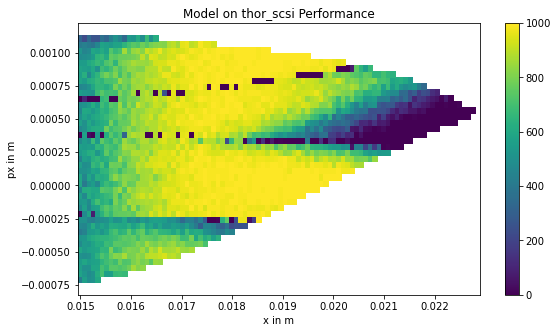

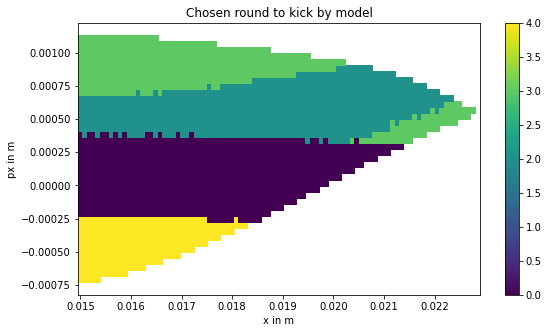

In [12]:
x_list = np.linspace(15e-3,22.85e-3,90)
px_list = np.linspace(-0.0008,0.0012,45)

fig, ax = plt.subplots(figsize=(9,5))

pc = ax.pcolormesh(x_list,px_list,Z.T,shading='auto')
fig.colorbar(pc)
 
plt.title(f"Model on thor_scsi Performance")
plt.ylabel("px in m")
plt.xlabel("x in m")
plt.show()

fig, ax = plt.subplots(figsize=(9,5))

pc = ax.pcolormesh(x_list,px_list,Z_round.T,shading='auto')
fig.colorbar(pc)
 
plt.title(f"Chosen round to kick by model")
plt.ylabel("px in m")
plt.xlabel("x in m")
plt.show()